In [1]:
!pip3 install pyLDAvis

In [20]:
#Linear Discriminant Analysis is a popular technique for performing dimensionality reduction on a dataset. Dimensionality reduction is the reduction of a dataset from  n  variables to  k  variables, 
#where the  k  variables are some combination of the  n  variables that preserves or maximizes some useful property of the dataset. In the case of Linear Discriminant Analysis, 
#the new variables are chosen (and the data reprojected) in a way that maximizes the linear separability of a certain set of classes in the underlying data.

import os
import pandas as pd
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go
import gensim
from gensim import corpora, models, similarities
import logging
import tempfile
from nltk.corpus import stopwords
from string import punctuation
from collections import OrderedDict
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
%matplotlib inline

init_notebook_mode(connected=True) #do not miss this line

import warnings
warnings.filterwarnings("ignore")


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
datafile = "/content/drive/MyDrive/Machine Leaning/pokemon.csv"

In [23]:
import pandas as pd
pokemon = pd.read_csv(datafile)
pokemon.head(5)

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,against_grass,against_ground,against_ice,against_normal,against_poison,against_psychic,against_rock,against_steel,against_water,attack,base_egg_steps,base_happiness,base_total,capture_rate,classfication,defense,experience_growth,height_m,hp,japanese_name,name,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,1.0,2.0,1.0,1.0,2.0,1.0,1.0,0.5,49,5120,70,318,45,Seed Pokémon,49,1059860,0.7,45,Fushigidaneフシギダネ,Bulbasaur,88.1,1,65,65,45,grass,poison,6.9,1,0
1,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,1.0,2.0,1.0,1.0,2.0,1.0,1.0,0.5,62,5120,70,405,45,Seed Pokémon,63,1059860,1.0,60,Fushigisouフシギソウ,Ivysaur,88.1,2,80,80,60,grass,poison,13.0,1,0
2,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,1.0,2.0,1.0,1.0,2.0,1.0,1.0,0.5,100,5120,70,625,45,Seed Pokémon,123,1059860,2.0,80,Fushigibanaフシギバナ,Venusaur,88.1,3,122,120,80,grass,poison,100.0,1,0
3,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,0.50,2.0,0.5,1.0,1.0,1.0,2.0,0.5,2.0,52,5120,70,309,45,Lizard Pokémon,43,1059860,0.6,39,Hitokageヒトカゲ,Charmander,88.1,4,60,50,65,fire,NaN,8.5,1,0
4,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,0.50,2.0,0.5,1.0,1.0,1.0,2.0,0.5,2.0,64,5120,70,405,45,Flame Pokémon,58,1059860,1.1,58,Lizardoリザード,Charmeleon,88.1,5,80,65,80,fire,NaN,19.0,1,0


In [24]:
len(pokemon[pokemon['type2'].isnull()])

384

In [25]:
#In order to avoid stat munging due to Pokemon with combined types, we're going to focus only on Pokemon with a single type (e.g. no dual types allowed).
#Notice also that we're normalizing the data before applying LDA. Normalization isn't strictly necessary, as you will get the same result without it, 
#just with differently sized numbers. I apply normalization as a preprocessing step here in order to make the class coefficients larger (and a bit easier on the eyes).

df = pokemon[pokemon['type2'].isnull()].loc[
    :, ['sp_attack', 'sp_defense', 'attack', 'defense', 'speed', 'hp', 'type1']
]
X = df.iloc[:, :-1].values

from sklearn.preprocessing import normalize
X_norm = normalize(X)

y = df.iloc[:, -1].values

In [26]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=3)
lda.fit(X_norm, y)

LinearDiscriminantAnalysis(n_components=3, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

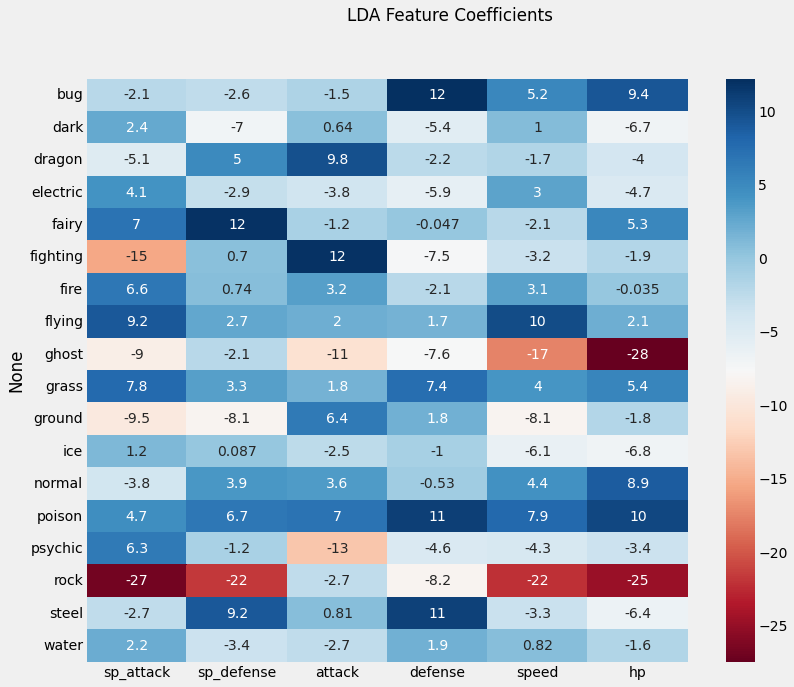

In [27]:
# Q: What is the deal with these priors?

#Assessing class-wise variable importance using LDA coefficients PCA provides a components_ attribute to the fitted reducer, which allows us to directly access the vector components. 
#LDA does not provide this attribute. This is because in LDA, the methodology for transforming a vector is a bit more complicated than a simple w.T * x reprojection.

#An LDA instead provides a coef_ attribute, which is analogous, albeit more mathematically complicated. The magnitudes of the components in the coef_ tell us how heavily each of the features 
#loads towards the seperability of that class.

#If a particular class has a particularly high-magnitude coefficient (direction, positive or negative, notwithstanding) then that variable signals that class very well. 
#That variable will factor very heavily into the LDA preprojection. A low-magnitude coefficient, meanwhile, corresponds with a weak signal, and 
#hence will be mostly rubbed out in the reprojection.

#If a class has mostly low-magnitude coefficients, that means that it is not easily linearly separable! That class is relatively close to the mean of the dataset or 
#(in the weaker cases) relatively close to a subset of other classes in the dataset.

#The heatmap that follows demonstrates what this maps out to:


import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import numpy as np

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

sns.heatmap(pd.DataFrame(lda.coef_, 
                         columns=df.columns[:-1], 
                         index=[lda.classes_]), 
            ax=ax, cmap='RdBu', annot=True)

plt.suptitle('LDA Feature Coefficients')
pass

In [28]:
#In this heatmap we see classes which are probably easier to separate, given their large variable coefficients, as well as classes which are probably much harder.

#A good example of a separable class is the rock type. Rock type Pokemon load very strongly on all of Special Attack, Special Defense, Speed, and HP, 
#implying that a combination of these stats makes up the Rock archetype. 
#Other highly separable classes are the ghost type and the fighting type, which both sport some high-magnitude coefficients.

#ice and water are two classes that have very low class separability. They both have coefficients that are mostly close to 0.

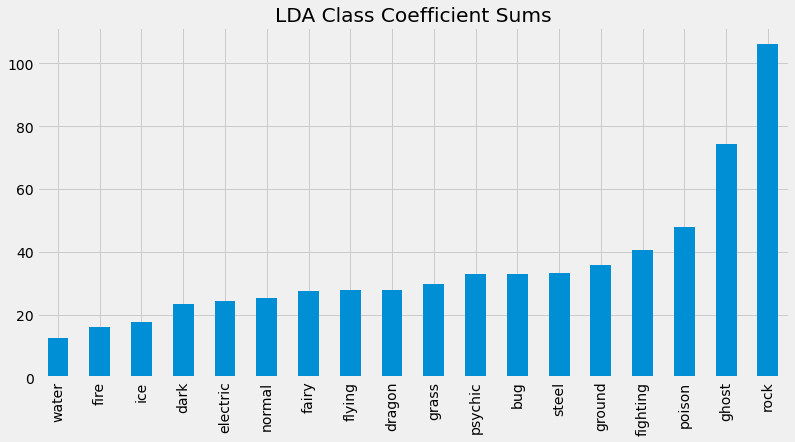

In [29]:
#We can summarize this heatmap by looking at the absolute coefficient totals for each of the classes.

pd.Series(np.abs(lda.coef_).sum(axis=1), index=lda.classes_).sort_values().plot.bar(
    figsize=(12, 6), title="LDA Class Coefficient Sums"
)

In [30]:
#Again, we see that rock and ghost is much more separable than water and ice.

#The y-values in both the heatmap and the bar plot can be treated as indicial. Higher is better, but the numbers themselves are not particularly interpretable 
#(at least, my math isn't strong enough to interpret them immediately; 
#feel free to think otherwise in the comments).

#To see what this difference translates to and to understand how well we perform overall, we need to move on to applying our LDA.

#To start with, as with any dimensionality reduction technique, it's important to note that each additional component used by the model adds less and less "gain" to the reconstructions. 
#For example, here are the top three explained variances of the LDA decomposition

lda.explained_variance_ratio_


array([0.48036548, 0.21001446, 0.13047873])

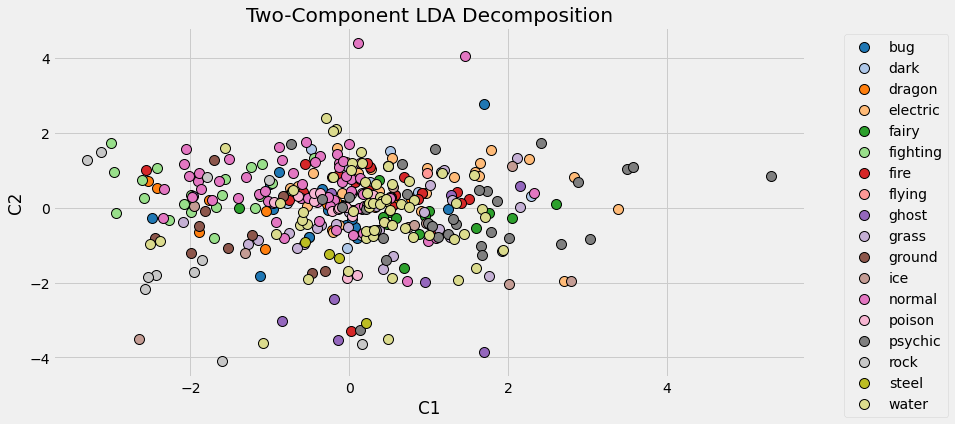

In [31]:
#Recall that PCA picks values which maximize these values directly. LDA picks values that maximize the differences between classes, so the explained_variance_ratio_ will not correlate 
#exactly with the usefulness of this or that particular vector. However, in practice LDA creates axes which are reasonably close to the axes created by PCA 
#(maximizing explained variance and maximizing class separability are reasonably similar tasks). 

X_hat = lda.fit_transform(X, y)

import matplotlib as mpl

colors = mpl.cm.get_cmap(name='tab20').colors
categories = pd.Categorical(pd.Series(y)).categories
ret = pd.DataFrame(
    {'C1': X_hat[:, 0], 'C2': X_hat[:, 1], 'Type': pd.Categorical(pd.Series(y))}
)

fig, ax = plt.subplots(1, figsize=(12, 6))

for col, cat in zip(colors, categories):
    (ret
         .query('Type == @cat')
         .plot.scatter(x='C1', y='C2', color=col, label=cat, ax=ax,
                       s=100, edgecolor='black', linewidth=1,
                       title='Two-Component LDA Decomposition')
         .legend(bbox_to_anchor=(1.2, 1))
    )